# __0. Imports__

In [54]:
from secret_key import Secret
import pandas as pd
import requests
import matplotlib.pyplot as plt
import pandas as pd
import mplfinance as mpf
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split



<h1>
    <b>1. Requesting the data</b>
</h1>
<h4><i> Here I explain the 'parameters' that the <b>api url</b> requires</i></h4>
<h2>
    <b>1.1 API Parameters</b>
</h2>
<ul>
    <li>
        <strong> Ticker</strong>
        <ul>
            <li><u>JSON FIELD:</u>
            </li>
            <li><u>DATA TYPE:</u> string
            </li>
            <li><u>REQUIRED:</u>
            </li>
        </ul>
    </li>
    <li> 
        <strong>Start Date</strong>
        <ul>
            <li><u>JSON FIELD:</u>
            </li>
            <li>DATA TYPE: date (YYYY-MM-DD)
            </li>
            <li>REQUIRED:
            </li>
        </ul>
    </li>
    <li>
        <strong>End Date</strong>
        <ul>
            <li>JSON FIELD:
            </li>
            <li>DATA TYPE:date (YYYY-MM-DD)
            </li>
            <li>REQUIRED:
            </li>
        </ul>
    </li>
    <li>
        <strong> Resample Freq</strong>
        <ul>
            <li>JSON FIELD:
            </li>
            <li>DATA TYPE: string (e.g. "15min" or "4hour". )
            </li>
            <li>REQUIRED:
            </li>
            <li>DEFAULT:5min
            </li>
        </ul>
    </li>
    <li>
        <strong>Response Format</strong>
        <ul>
            <li>JSON FIELD:
            </li>
            <li>DATA TYPE: string
            </li>
            <li>REQUIRED:
            </li>
            <li>DEFAULT: JSON
            </li>
        </ul>
    </li>
</ul>


In [3]:
headers =  {
    'Content-Type' : 'application/json'
}

In [46]:
ticker = 'EURUSD'
start_date = '2024-03-15'

In [47]:
requestResponse = requests.get(f"https://api.tiingo.com/tiingo/fx/{ticker.lower()}/prices?startDate={start_date}&resampleFreq=5min&token=ebed6535a2acbe1a06b0057e8d1e8af61e5cefa7", headers=headers)

In [48]:
data = requestResponse.json() 
data 

[{'date': '2024-03-15T00:00:00.000Z',
  'ticker': 'eurusd',
  'open': 1.088275,
  'high': 1.088465,
  'low': 1.088165,
  'close': 1.08821},
 {'date': '2024-03-15T00:05:00.000Z',
  'ticker': 'eurusd',
  'open': 1.088205,
  'high': 1.088225,
  'low': 1.0879,
  'close': 1.08796},
 {'date': '2024-03-15T00:10:00.000Z',
  'ticker': 'eurusd',
  'open': 1.087955,
  'high': 1.088005,
  'low': 1.08785,
  'close': 1.08785},
 {'date': '2024-03-15T00:15:00.000Z',
  'ticker': 'eurusd',
  'open': 1.087855,
  'high': 1.088015,
  'low': 1.087855,
  'close': 1.087965},
 {'date': '2024-03-15T00:20:00.000Z',
  'ticker': 'eurusd',
  'open': 1.087955,
  'high': 1.087995,
  'low': 1.08785,
  'close': 1.087865},
 {'date': '2024-03-15T00:25:00.000Z',
  'ticker': 'eurusd',
  'open': 1.087875,
  'high': 1.087885,
  'low': 1.087705,
  'close': 1.08771},
 {'date': '2024-03-15T00:30:00.000Z',
  'ticker': 'eurusd',
  'open': 1.087715,
  'high': 1.087935,
  'low': 1.087715,
  'close': 1.08786},
 {'date': '2024-03-15T

# __2. Analysis & Processing__

<h2><strong>2.1 Basic Analysis</strong></h2>

In [55]:
df.dtypes

ticker     object
open      float64
high      float64
low       float64
close     float64
dtype: object

In [49]:
df= pd.DataFrame(data)
df.sample(5)

,date,ticker,open,high,low,close
179,2024-03-15T14:55:00.000Z,eurusd,1.088965,1.089035,1.088755,1.088805
54,2024-03-15T04:30:00.000Z,eurusd,1.087630,1.087645,1.087625,1.087635
90,2024-03-15T07:30:00.000Z,eurusd,1.088155,1.088315,1.088105,1.088265
245,2024-03-15T20:25:00.000Z,eurusd,1.088790,1.088925,1.088785,1.088925
95,2024-03-15T07:55:00.000Z,eurusd,1.088285,1.088285,1.087885,1.088095


In [50]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

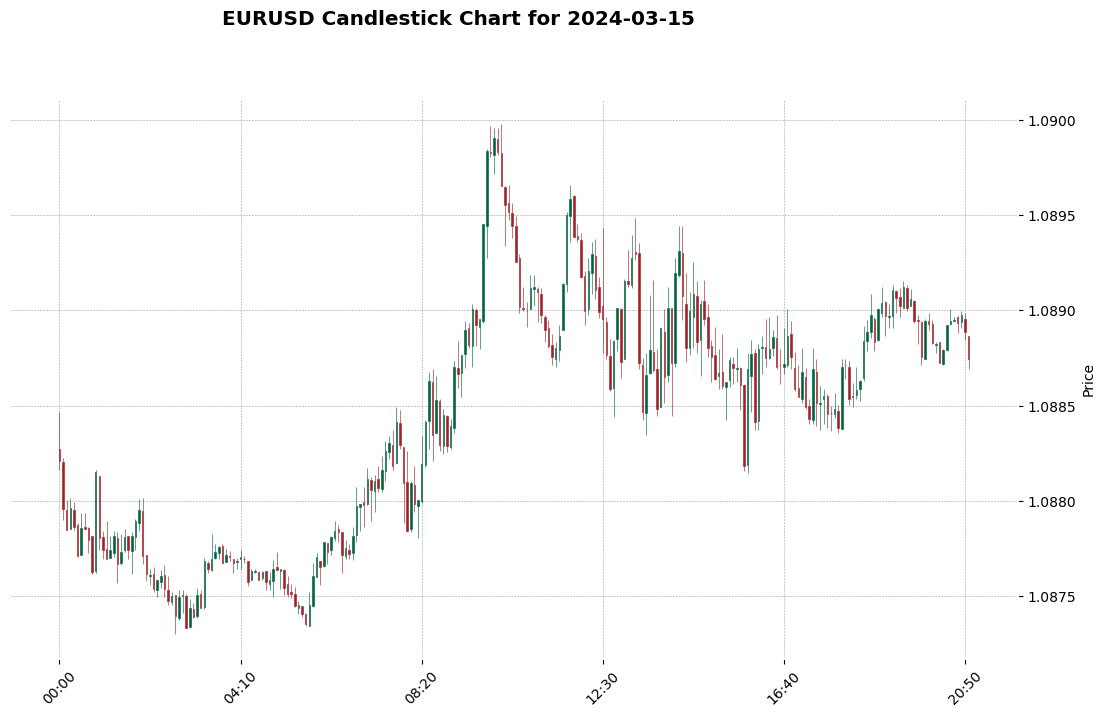

In [53]:

mpf.plot(
    df, 
    type='candle', 
    style='charles', 
    title=f'{ticker} Candlestick for {start_date}', 
    ylabel='Price', 
    ylabel_lower='Volume',  
    figsize=(14, 8)
    )


<h2><strong>2.2 Preprocessing</strong></h2>

In [56]:
scaler = StandardScaler()
numerical_features = ['open', 'high', 'low', 'close']  # Assuming these are your numerical features
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [57]:
X = df.drop('target_column', axis=1)  # Features
y = df['target_column']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


KeyError: "['target_column'] not found in axis"